In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-text
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow_hub as hub
import tensorflow as tf
tf.config.list_physical_devices('GPU')
import tensorflow_text
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from keras.models import load_model

In [3]:
balanced_lyrics = pd.read_csv('./../dataset/balanced_lyrics.csv')

In [4]:
balanced_lyrics["Mood"].value_counts()

Happy      620
Sad        620
Relaxed    620
Angry      618
Name: Mood, dtype: int64

In [5]:
balanced_lyrics.sample(5)

,Unnamed: 0,TrackId,ArtistName,Title,Lyrics,Mood
1383,641,TRYGIRP128F93236A8,Saul Williams,Black Stacey,hump pillow night type silent prayer help prep...,Angry
789,2377,TRWIVZY128F427199F,Katatonia,Evidence,hold breath check time minute collapse knew th...,Sad
1087,3461,TRTGYPP128E07819EE,The Sundays,She,weak heart beats cant speak lights low crowd F...,Sad
1573,33,TRZEZST128F42A1E7B,Kelly Clarkson,Low,Everybodys talking thing look sad eyes want sy...,Angry
1509,3057,TRIFDSP128F428B1FB,SR-71,Goodbye,Im know wonder friend foe Im burning throat sw...,Angry


In [6]:
def encode(x):
    if x=="Happy":
        return 0
    elif x=="Sad":
        return 1
    elif x=="Angry":
        return 2
    else:
        return 3

In [7]:
balanced_lyrics["Mood_Values"] = balanced_lyrics["Mood"].apply(lambda x: encode(x))

In [8]:
balanced_lyrics.sample(5)

,Unnamed: 0,TrackId,ArtistName,Title,Lyrics,Mood,Mood_Values
217,1139,TROGWKP128F4255C9C,Ivoryline,We Both Know,know cant plan real takes plans feel like know...,Happy,0
1568,2826,TRIFEHI128F427CEB4,Mando Diao,How We Walk,react situation like birds aint singing know k...,Angry,2
1524,1856,TRYTRSH128F148D600,Powerman 5000,Action,Ahh Go sky falling curious condition aint fall...,Angry,2
1722,1289,TRTEGUJ128F425B7D3,Foo Fighters,The Pretender,dark know pretend dark began Send skeletons Si...,Angry,2
418,511,TRNLQNP128F1463ADF,James,Sometimes,Theres storm outside gap crack thunder Crack t...,Happy,0


In [9]:
labels = np.zeros((len(balanced_lyrics), 4))
labels.shape

(2478, 4)

In [10]:
labels

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [11]:
np.arange(len(balanced_lyrics))

array([   0,    1,    2, ..., 2475, 2476, 2477])

In [12]:
balanced_lyrics["Mood_Values"].values

array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

In [13]:
labels[np.arange(len(balanced_lyrics)), balanced_lyrics["Mood_Values"].values] = 1

In [14]:
labels = pd.DataFrame(labels)
labels.columns = ['happy', 'sad', 'angry', 'relaxed']
labels.sample(5)

,happy,sad,angry,relaxed
2028,0.0,0.0,0.0,1.0
2210,0.0,0.0,0.0,1.0
729,0.0,1.0,0.0,0.0
1651,0.0,0.0,1.0,0.0
1284,0.0,0.0,1.0,0.0


In [16]:
balanced_lyrics["Title_and_Artist"] = balanced_lyrics["Title"].astype(str) + " by " + balanced_lyrics["ArtistName"].astype(str)

In [17]:
balanced_lyrics.sample(5)

,Unnamed: 0,TrackId,ArtistName,Title,Lyrics,Mood,Mood_Values,Title_and_Artist
75,2845,TRJWZRG128F14B0A82,Newsboys,Miracle Child,got sure come late paid lip service address pr...,Happy,0,Miracle Child by Newsboys
765,3674,TRDUOSF128F92EF905,Telefon Tel Aviv,The Birds,answer bend head run away true wish Cause talk...,Sad,1,The Birds by Telefon Tel Aviv
893,1969,TRZEUSA128F148AE3E,Dashboard Confessional,Screaming Infidelities,Im missing bed sleep Avoiding spots wed speak ...,Sad,1,Screaming Infidelities by Dashboard Confessional
59,410,TRVENBM128F4265F7D,G. Love & Special Sauce,Baby's Got Sauce,Cooling cooling Waiting form lady got special ...,Happy,0,Baby's Got Sauce by G. Love & Special Sauce
2107,3857,TRQTGOY128F9303416,Hybrid,I Know,Everyday changes names faces situations rules ...,Relaxed,3,I Know by Hybrid


In [18]:
X_train, X_val, y_train, y_val = train_test_split(
    balanced_lyrics["Title_and_Artist"].values,
    labels.values,
    stratify=balanced_lyrics["Mood_Values"],
    random_state=42,
    train_size=0.75
)

# MODELLING

In [22]:
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

bert_preprocess_model = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

bert_preprocess_model.save('./../models/bert_preprocess_model.h5')
bert_encoder.save('./../models/bert_encoder.h5')

AttributeError: 'KerasLayer' object has no attribute 'save'

In [23]:
text_test = ['In the Action Learning Week']
text_processed = bert_preprocess_model(text_test)

In [24]:
text_processed

{'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

In [25]:
bert_result = bert_encoder(text_processed)
bert_result['encoder_outputs'][-1]

<tf.Tensor: shape=(1, 128, 768), dtype=float32, numpy=
array([[[-0.45691183, -0.07244778, -0.23398802, ..., -0.20231889,
          0.42765385,  0.22600639],
        [-1.0092791 , -0.50828385, -0.4714317 , ..., -0.03971374,
          0.6122011 ,  0.38416702],
        [-0.9044275 , -0.6946019 , -0.35650998, ...,  0.25836554,
          0.4475322 , -0.45108443],
        ...,
        [-0.23737016, -0.24208722,  0.08189254, ...,  0.08045697,
          0.24774677,  0.0395791 ],
        [-0.2725888 , -0.25035655,  0.05305065, ...,  0.12572117,
          0.1871587 ,  0.06329314],
        [-0.11328268, -0.21856053,  0.02244496, ...,  0.13156804,
          0.0859606 ,  0.05084686]]], dtype=float32)>

In [26]:
def get_sentence_embedding(sentences):
    preprocessed_text = bert_preprocess_model(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [27]:
get_sentence_embedding(['grapes', 'mangoes'])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8602321 , -0.21242943,  0.49156895, ...,  0.3979803 ,
        -0.60506284,  0.8447165 ],
       [-0.9174945 , -0.31882355, -0.777514  , ..., -0.52995986,
        -0.75241315,  0.9206705 ]], dtype=float32)>

In [111]:
# BERT Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess_model(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural Network Layers
network = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
network = tf.keras.layers.Dense(4, activation="softmax", name="output")(network)

# Construct final Model
bert_model = tf.keras.Model(inputs=[text_input], outputs=[network])

In [112]:
bert_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [113]:
METRICS = [
    tf.keras.metrics.Accuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.AUC(name='auc')
]

bert_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS
)

In [114]:
latest = tf.train.latest_checkpoint('/content/drive/MyDrive/action-learning/song_bert_train_weights')
latest

'/content/drive/MyDrive/action-learning/song_bert_train_weights/cp-0003.ckpt'

In [115]:
if latest != None:
    bert_model.load_weights(latest)

In [116]:
checkpoint_path = "/content/drive/MyDrive/action-learning/song_bert_train_weights/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

check_point_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_best_only=True
)

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6
)

In [117]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [118]:
time_callback = TimeHistory()

In [119]:
history = bert_model.fit(
    x=X_train,
    y=y_train,
    epochs=15,
    validation_data=(X_val, y_val),
    callbacks=[check_point_cb, early_stop_cb]
)

bert_model.save('/content/drive/MyDrive/action-learning/song_bert_training_saved_models/song_bert_after_21_epochs.h5')

Epoch 1/15
59/59 [==============================] - ETA: 0s - loss: 1.4015 - accuracy: 0.0000e+00 - precision: 0.3607 - auc: 0.5450 
Epoch 1: val_loss improved from inf to 1.37703, saving model to /content/drive/MyDrive/action-learning/song_bert_train_weights/cp-0001.ckpt
59/59 [==============================] - 801s 14s/step - loss: 1.4015 - accuracy: 0.0000e+00 - precision: 0.3607 - auc: 0.5450 - val_loss: 1.3770 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.5544
Epoch 2/15
59/59 [==============================] - ETA: 0s - loss: 1.4137 - accuracy: 0.0000e+00 - precision: 0.2935 - auc: 0.5477 
Epoch 2: val_loss did not improve from 1.37703
59/59 [==============================] - 805s 14s/step - loss: 1.4137 - accuracy: 0.0000e+00 - precision: 0.2935 - auc: 0.5477 - val_loss: 1.4284 - val_accuracy: 0.0000e+00 - val_precision: 0.3578 - val_auc: 0.5401
Epoch 3/15
59/59 [==============================] - ETA: 0s - loss: 1.4098 - accuracy: 0.0000e+00 - precision: 0.

In [109]:
times = time_callback.times
times

[810.344583272934, 877.0614221096039, 878.1207194328308]

In [92]:
y_pred = bert_model.predict(X_val[:3])

1/1 [==============================] - 3s 3s/step


In [25]:
print(X_train[:2])
print(y_train[:2])

['Four Leaf Clover by Badly Drawn Boy' 'Heart of Chambers by Beach House']
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]]


In [93]:
y_pred_emotion_value = [np.argmax(i) for i in y_pred]
y_pred_emotion_value

[2, 0, 2]

In [94]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "precision", "auc", "val_loss", "val_accuracy", "val_precision", "val_auc"]
    hist_df.index = np.arange(1, len(hist_df)+1)
    
    fig, axs = plt.subplots(nrows=4, sharex=True, figsize=(16, 20))

    axs[0].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[0].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)

    axs[1].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[1].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    axs[2].plot(hist_df.val_precision, lw=3, label='validation Precision')
    axs[2].plot(hist_df.precision, lw=3, label='Training Precision')
    axs[2].set_ylabel('Precision')
    axs[2].set_xlabel('Epoch')
    axs[2].grid()
    axs[2].legend(loc=0)

    axs[3].plot(hist_df.val_auc, lw=3, label='Validation AUC')
    axs[3].plot(hist_df.auc, lw=3, label='Training AUC')
    axs[3].set_ylabel('AUC')
    axs[3].set_xlabel('Epoch')
    axs[3].grid()
    axs[3].legend(loc=0)

    plt.show();

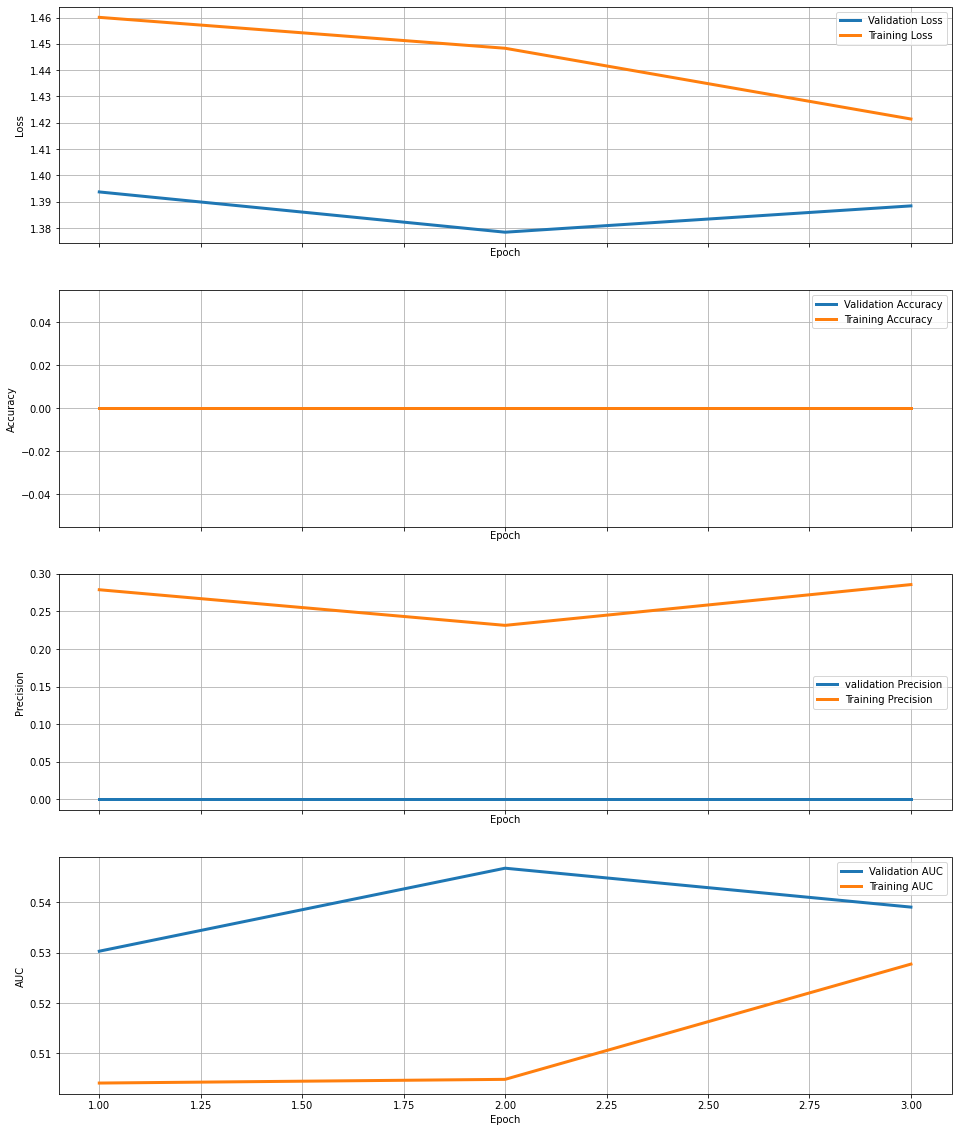

In [95]:
plot_results(history)